Plotting of the quarterly data fro Kepler-10

!!! STEP ON TUPLA MUUTTUJA PIIKKIEN POISTOSSA JA FRM METODISSA, JOKA PITÄÄ KORJATA!!!

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import os
import glob
import bisect
import warnings
import time as time_method
from ps import powerspectrum
from statistics import mean
from scipy.ndimage import gaussian_filter
from astropy.convolution import convolve, Box1DKernel

In [1]:
def pick(x,y): #pass only the 1's
    sx = x.copy()
    sy = y.copy()
    for i in range(len(index)-1,-1,-1):
        if score[index[i]] == 0:
            sx.pop(i)
            sy.pop(i)
            index.pop(i)
    nbr_noise = 1-(len(sx))/(len(x))
    if nbr_noise > 0.02:
        print("Precentage of removed datapoints might be too high: {} with precentage {}.".format(files, nbr_noise))
    return sx, sy

def reject_outliers(rx, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zeros(len(d))
    return data[s<m]

def poldiff(dx,dy): #Returns one scaled array
    coeff = np.polyfit(dx,dy,7) 
    p = np.poly1d(coeff)
    raja=[0]*len(dy)
    for i in range(0,len(dx)):
        raja[i] = dy[i]/p(dx[i])-1
    cut = 5*np.median(np.absolute(raja))
    for i in range(0,len(dx)):
        if abs(raja[i])>=cut:
            score[index[i]]=0
    return raja
    

def neighbour(nx,ny): #need to pass only the 1's, doesn't have a return value as it only alters the score
    lcut = 4*np.median(np.absolute(ny))
    for i in range(2,len(nx)-2):
        if math.isnan(ny[i]) == True or math.isnan(nx[i]) == True:
            print("Mistake!")
            continue
        line = np.polyfit([nx[i-2],nx[i-1],nx[i+1],nx[i+2]], [ny[i-2],ny[i-1],ny[i+1],ny[i+2]], 1)
        l = np.poly1d(line)
        if abs(abs(ny[i])-abs(l(nx[i]))) >= lcut:
            score[i]=0
            
def __transit__(period, tx, ty):
    bins = int(len(tx)/500)
    if bins < 500:
        bins = 500
    for i in range(0,len(tx)):
        tx[i] = tx[i] % period
    new = pd.DataFrame({'Time mod P':tx, 'FLux':ty})
    quartiles = pd.qcut(new['Time mod P'], bins, labels=range(0,bins))
    new = new.assign(Quartile=quartiles.values)

    #testi = []
    new_time = []
    new_flux = []
    for i in range(0,bins):
        picked = new.loc[new['Quartile'] == i]
        new_flux.append(picked.loc[:, 'FLux'].median())
        new_time.append(picked.loc[:, 'Time mod P'].median())
    return new_time, new_flux

def find_closest(num):
    max_index = len(new_time)
    indeksi = bisect.bisect(new_time, num)
    if indeksi < max_index:
        if abs(new_time[indeksi-1]-num) > abs(new_time[indeksi]-num):
            indeksi -= 1
    elif indeksi == max_index:
        if abs(new_time[0]-num) > abs(new_time[max_index-1]-num):
            indeksi = 0
    
    return indeksi


def power_peaks(): #To be always runned after power spectrum on Power
    #We want the following windows to flatten the peaks
    flatten_peak(3964.8,3965.5)
    flatten_peak(4531.1,4531.6)
    flatten_peak(5097.7,5098.1)
    flatten_peak(7876.2,7876.8)

def flatten_peak(c,d): 
    Power_part = Power[round(c/step):round(d/step)]
    med_part = np.median(Power_part)
    while max(Power_part) > med_part:
        Power[find_peak(round(c/step),round(d/step))] -= med_part
        Power_part = Power[round(c/step):round(d/step)]
        
def find_peak(a,b):
    suurin_arvo = 0
    for j in range(a,b):
        if Power[j] > suurin_arvo:
            suurin_arvo = Power[j] 
            suurin_indeksi = j
    return (suurin_indeksi)

Precentage of removed datapoints might be too high: C:\Users\pars3\OneDrive - Aarhus universitet\Gradu\data\test\kplr011904151-2009291181958_slc.dat with precentage 0.03243546576879908.
Precentage of removed datapoints might be too high: C:\Users\pars3\OneDrive - Aarhus universitet\Gradu\data\test\kplr011904151-2010265121752_slc.dat with precentage 0.020969023034154044.
Precentage of removed datapoints might be too high: C:\Users\pars3\OneDrive - Aarhus universitet\Gradu\data\test\kplr011904151-2010355172524_slc.dat with precentage 0.021886973180076597.
Precentage of removed datapoints might be too high: C:\Users\pars3\OneDrive - Aarhus universitet\Gradu\data\test\kplr011904151-2012211050319_slc.dat with precentage 0.055529595015576305.
Precentage of removed datapoints might be too high: C:\Users\pars3\OneDrive - Aarhus universitet\Gradu\data\test\kplr011904151-2012341132017_slc.dat with precentage 0.062359697206995524.
Precentage of removed datapoints might be too high: C:\Users\pars3

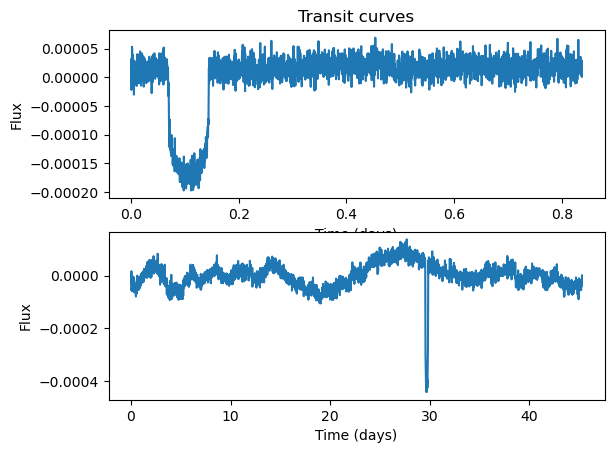

In [5]:
#RUN THE WHOLE DATASET
files_path = r"C:\Users\pars3\OneDrive - Aarhus universitet\Gradu\data\test"
read_files = glob.glob(os.path.join(files_path,"*.dat"))
warnings.filterwarnings("ignore")

time_test = []
flux_test = []
full_x = []
full_y = []


for files in read_files:
    muuttuja = pd.read_csv(files, delimiter='\s+', comment='#',header=None,)
    time_test = muuttuja[muuttuja.columns[:1]].to_numpy()
    flux_test = muuttuja[muuttuja.columns[1:2]].to_numpy()
    lenght = len(time_test)
    fx=[0]*lenght
    fy=[0]*lenght
    score=[1]*lenght
    index = np.arange(0, lenght).tolist()
    for i in range(0,lenght): #turning df[[]] to arrays of floats
        fx[i] = float(time_test[i])
        fy[i] = float(flux_test[i])
        if np.isfinite(fy[i]) == False or math.isnan(fy[i]) == True: #Finding and removing infinities
            score[i] = 0
        if math.isnan(fy[i]) == True:
            print("Error")
    
    #For every file we correct once with polynomial and then neighboour fit
    (fx,fy) =pick(fx,fy)
    fy = poldiff(fx,fy) 
    (fx, fy) = pick(fx, fy)
    neighbour(fx,fy)
    (fx,fy) =pick(fx,fy)
    #Gathering all the files to same list
    full_x.extend(fx)
    full_y.extend(fy)

plt.show()
changed_x = full_x.copy()
changed_y = full_y.copy()
#period = 0.83749
(new_time,new_flux) = __transit__(0.83749,changed_x,changed_y)
plt.subplot(2, 1, 1)
plt.plot(new_time, new_flux)
plt.title('Transit curves')
plt.xlabel('Time (days)')
plt.ylabel('Flux')
#Deleting the transit
for i in range(0,len(full_x)):
    numero = changed_x[i] % 0.837491
    ind = find_closest(numero)
    full_y[i] -= new_flux[ind] #pitäisikö poistaa abs
changed_x = full_x.copy()
changed_y = full_y.copy()
(new_time,new_flux) = __transit__(45.2943,changed_x,changed_y)

plt.subplot(2, 1, 2)
plt.plot(new_time, new_flux)
plt.xlabel('Time (days)')
plt.ylabel('Flux')
#Deleting the transit
for i in range(0,len(full_x)):
    numero = changed_x[i] % 45.2943
    ind = find_closest(numero)
    full_y[i] -= new_flux[ind]

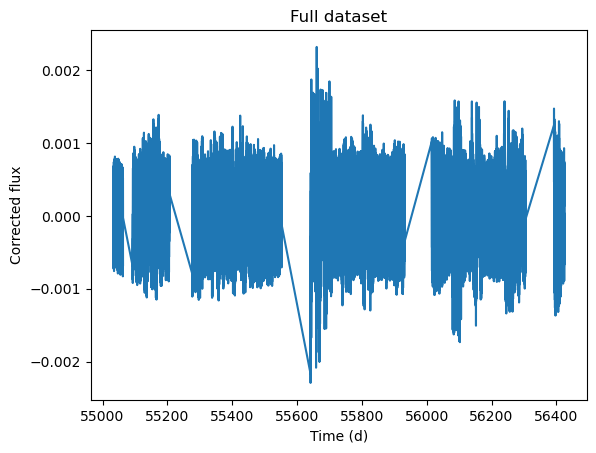

In [6]:
plt.plot(full_x, full_y)
plt.xlabel('Time (d)')  
plt.ylabel('Corrected flux')  
plt.title("Full dataset") 
plt.show()